In [1]:
import json

def read_json_file(file_path: str):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data
        
file_path = 'library.json'
library = read_json_file(file_path)

In [2]:
library.keys()

dict_keys(['2024-09-14_17-31-17.json', '2024-09-14_17-40-11.json', '2024-09-14_17-36-03.json'])

In [3]:
first_scan = library['2024-09-14_17-31-17.json']
secound_scan = library['2024-09-14_17-36-03.json']

In [4]:
import numpy as np
def translate(points, offset):
    """
    Translate points by an offset.
    :param points: List of [x, y, z] points
    :param offset: Offset to translate points [dx, dy, dz]
    :return: Translated points
    """
    translation_matrix = np.array(offset)
    translated_points = points + translation_matrix
    return translated_points

def rotate(points, angle, axis):
    """
    Rotate points around an axis by a certain angle.
    :param points: List of [x, y, z] points
    :param angle: Angle in degree
    :param axis: Axis to rotate around ('x', 'y', or 'z')
    :return: Rotated points
    """

    angle = np.deg2rad(angle)
    if axis == 'x':
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, np.cos(angle), -np.sin(angle)],
                                    [0, np.sin(angle), np.cos(angle)]])
    elif axis == 'y':
        rotation_matrix = np.array([[np.cos(angle), 0, np.sin(angle)],
                                    [0, 1, 0],
                                    [-np.sin(angle), 0, np.cos(angle)]])
    elif axis == 'z':
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                    [np.sin(angle), np.cos(angle), 0],
                                    [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")

    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points

def transform_points(points, settings):
    """
    Transform points by translation and rotation.
    :param points: List of [x, y, z] points
    :param settings: Dictionary containing 'offset', 'angles', and 'axes' keys
    :return: Transformed points
    """
    offset = settings.get('offset', [0, 0, 0])
    angles = settings.get('angles', [])
    axes = settings.get('axes', [])
    
    points = np.array(points)
    points = translate(points, offset)
    
    for angle, axis in zip(angles, axes):
        points = rotate(points, angle, axis)
    
    return points

def transform_point(point, settings):
    return transform_points([point], settings)[0]

# Example usage
points = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]  # List of 3D points
settings = {
    'offset': [1, 1, 1],  # Translation offset
    'angles': [30, 45, 30],  # Angles for rotation in radians
    'axes': ['x', 'y', 'z']  # Corresponding axes for the angles
}

# transformed_points = transform_points(points, settings)
# print("Transformed points:\n", transformed_points)

In [5]:
def point_cloud_with_zscore_filter(mean_points_cloud_dict, z_scores_threshold = 2.0):
    mean_coordinates = np.mean(list(mean_points_cloud_dict.values()), axis=0)
    std_dev_coordinates = np.std(list(mean_points_cloud_dict.values()), axis=0)

    filtered_identifier = set()
    for (identifier, point) in mean_points_cloud_dict.items():
        z_scores = np.abs((point - mean_coordinates) / std_dev_coordinates)
        z_scores = np.nan_to_num(z_scores)
        if np.all(z_scores < z_scores_threshold):
            filtered_identifier.add(identifier)

    return filtered_identifier

In [6]:
first_filtered_identifier = list(point_cloud_with_zscore_filter(first_scan['feature_points_mean']))
secound_filtered_identifier = list(point_cloud_with_zscore_filter(secound_scan['feature_points_mean']))

In [7]:
import pyvista as pv

In [8]:
transform = {
                'offset': [1.25, -0.07, -1.8],  # Translation offset
                'angles': [0, 25, 0],  # Angles for rotation in radians
                'axes': ['x','y','z']  # Corresponding axes for the angles
            }

points1 = np.array([first_scan['feature_points_mean'][identifier] for identifier in first_filtered_identifier])
alphas1 = np.array([first_scan['feature_points_appearing_conunt_normalized'][identifier] for identifier in first_filtered_identifier])

points2 = np.array([secound_scan['feature_points_mean'][identifier] for identifier in secound_filtered_identifier])
alphas2 = np.array([secound_scan['feature_points_appearing_conunt_normalized'][identifier] for identifier in secound_filtered_identifier])
points2 = transform_points(points2, transform)

plotter = pv.Plotter()

cloud1 = pv.PolyData(points1)
cloud1["alpha"] = alphas1
plotter.add_mesh(cloud1, render_points_as_spheres=True, point_size=2, scalars="alpha", opacity="alpha", cmap=['g'])

cloud2 = pv.PolyData(points2)
cloud2["alpha"] = alphas2
plotter.add_mesh(cloud2, render_points_as_spheres=True, point_size=2, scalars="alpha", opacity="alpha", cmap=['b'])

plotter.add_axes()
plotter.show_grid(color='black')

plotter.camera_position = 'xy'

plotter.show()

Widget(value='<iframe src="http://localhost:51302/index.html?ui=P_0x109565c10_0&reconnect=auto" class="pyvista…

In [9]:
def filter_dict_by_keys(original_dict, keys_to_keep):
    """
    Returns a new dictionary containing only the keys specified in keys_to_keep.

    Args:
    - original_dict (dict): The original dictionary to filter.
    - keys_to_keep (set or list): The set or list of keys to keep in the new dictionary.

    Returns:
    - dict: A new dictionary containing only the specified keys.
    """
    return {key: value for key, value in original_dict.items() if key in keys_to_keep}

In [10]:
intersec_identifiers = set(first_filtered_identifier).intersection(secound_filtered_identifier)
alphas1dict = filter_dict_by_keys(first_scan['feature_points_appearing_conunt_normalized'], intersec_identifiers)
alphas2dict = filter_dict_by_keys(secound_scan['feature_points_appearing_conunt_normalized'], intersec_identifiers)

In [11]:
sum_alpha = {key: alphas1dict[key]+alphas2dict[key] for key in intersec_identifiers}

In [12]:
import random

def weighted_sample(d):
    total_weight = sum(d.values())
    rand_value = random.uniform(0, total_weight)
    cumulative_weight = 0.0
    
    for key, weight in d.items():
        cumulative_weight += weight
        if rand_value < cumulative_weight:
            return key
weighted_sample(sum_alpha)

'1595164'

In [13]:
limit_sample = 50
sample_identifier = list(set(weighted_sample(sum_alpha) for i in range(limit_sample)))

In [14]:
transform = {
                'offset': [1.25, -0.07, -1.8],  # Translation offset
                'angles': [0, 25, 0],  # Angles for rotation in radians
                'axes': ['x','y','z']  # Corresponding axes for the angles
            }

In [15]:
lines = [ (first_scan['feature_points_mean'][identifier], transform_point(secound_scan['feature_points_mean'][identifier], transform)) for identifier in sample_identifier ]
lines[:3]

[([1.0884215666666677, -0.5799520933333334, -2.7259791166666676],
  array([-0.20676995, -0.0316412 , -4.31562863])),
 ([0.33826247266666626, -0.560323314666666, -4.299858286666669],
  array([-0.82183651, -0.80766104, -3.77553613])),
 ([0.6523416648148148, -1.5904987796296297, -4.762367374074072],
  array([-0.74261694, -0.55563632, -4.74995322]))]

In [16]:
def findDistanceBetweenPoints(p1: np.array, p2: np.array) -> float:
    """
    Calculate the Euclidean distance between two 3D points.

    Parameters:
    p1 (np.array): The first point [x1, y1, z1]
    p2 (np.array): The second point [x2, y2, z2]

    Returns:
    float: The Euclidean distance between the two points.
    """
    return np.linalg.norm(p1 - p2)

In [17]:
lines_point = []
line_dif = []

for line in lines:
    lines_point.append(line[0])
    lines_point.append(line[1])
    line_dif.append(findDistanceBetweenPoints(line[0],line[1]))

lines_point = np.array(lines_point)

lines_point[:5]


array([[ 1.08842157, -0.57995209, -2.72597912],
       [-0.20676995, -0.0316412 , -4.31562863],
       [ 0.33826247, -0.56032331, -4.29985829],
       [-0.82183651, -0.80766104, -3.77553613],
       [ 0.65234166, -1.59049878, -4.76236737]])

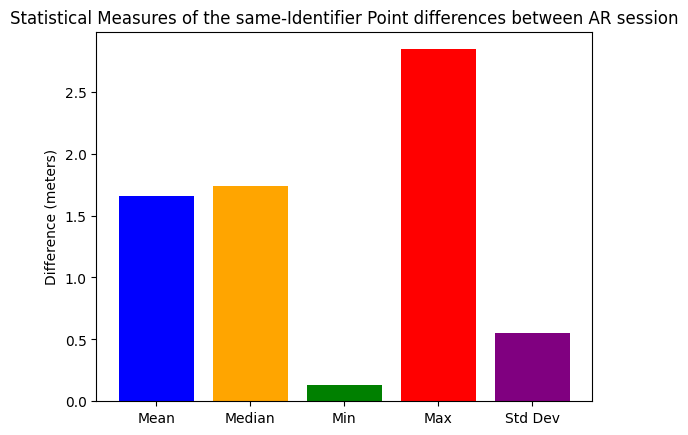

In [18]:
import matplotlib.pyplot as plt

# Calculate the statistics
mean = np.mean(line_dif)
median = np.median(line_dif)
minimum = np.min(line_dif)
maximum = np.max(line_dif)
std_dev = np.std(line_dif)

# Creating a dictionary for ease of plotting
stats = {
    'Mean': mean,
    'Median': median,
    'Min': minimum,
    'Max': maximum,
    'Std Dev': std_dev
}

# Plotting the statistics
fig, ax = plt.subplots()
ax.bar(stats.keys(), stats.values(), color=['blue', 'orange', 'green', 'red', 'purple'])

# Adding title and labels
ax.set_title('Statistical Measures of the same-Identifier Point differences between AR session')
ax.set_ylabel('Difference (meters)')

# Display the plot
plt.show()

In [19]:
points1 = np.array([first_scan['feature_points_mean'][identifier] for identifier in first_filtered_identifier])
alphas1 = np.array([first_scan['feature_points_appearing_conunt_normalized'][identifier] for identifier in first_filtered_identifier])

points2 = np.array([secound_scan['feature_points_mean'][identifier] for identifier in secound_filtered_identifier])
alphas2 = np.array([secound_scan['feature_points_appearing_conunt_normalized'][identifier] for identifier in secound_filtered_identifier])
points2 = transform_points(points2, transform)

plotter = pv.Plotter()

cloud1 = pv.PolyData(points1)
cloud1["alpha"] = alphas1
plotter.add_mesh(cloud1, render_points_as_spheres=True, point_size=2, scalars="alpha", opacity="alpha", cmap=['g'])

cloud2 = pv.PolyData(points2)
cloud2["alpha"] = alphas2
plotter.add_mesh(cloud2, render_points_as_spheres=True, point_size=2, scalars="alpha", opacity="alpha", cmap=['b'])

plotter.add_lines(lines_point, color='purple', width=1)

plotter.add_axes()
plotter.show_grid(color='black')

plotter.camera_position = 'xy'

plotter.show()

Widget(value='<iframe src="http://localhost:51302/index.html?ui=P_0x1609a8130_1&reconnect=auto" class="pyvista…